In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
print('Completed import lib')

Completed import lib


I. Import and clean data

In [6]:
cus = pd.read_csv ('/Users/huuchuyen0312/Downloads/Dataset/customers_dataset.csv')
orderitems = pd.read_csv ('/Users/huuchuyen0312/Downloads/Dataset/order_items_dataset.csv')
orderpay = pd.read_csv ('/Users/huuchuyen0312/Downloads/Dataset/order_payments_dataset.csv')
orderreviews = pd.read_csv ('/Users/huuchuyen0312/Downloads/Dataset/order_reviews_dataset.csv')
order = pd.read_csv ('/Users/huuchuyen0312/Downloads/Dataset/orders_dataset.csv')
productcat = pd.read_csv ('/Users/huuchuyen0312/Downloads/Dataset/product_category_name_translation.csv')
product= pd.read_csv ('/Users/huuchuyen0312/Downloads/Dataset/products_dataset.csv')
print ('complete upload data')

complete upload data


In [7]:
cus.info()  
orderitems.info()
orderpay.info()
orderreviews.info()
order.info()
productcat.info()
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_id       112650 non-null  object 
 1   order_item_id  112650 non-null  int64  
 2   product_id     112650 non-null  object 
 3   seller_id      112650 non-null  object 
 4   price          112650 non-null  float64
 5   freight_value  112650 non-null  fl

In [12]:
df= order.merge(orderitems, on=['order_id'], how='inner')
df= df.merge(orderpay, on=['order_id'], how= 'inner')
df= df.merge(product, on=['product_id'], how= 'inner')
df= df.merge(orderreviews, on=['order_id'], how='inner')
df= df.merge(cus, on=['customer_id'], how='inner')

1. Order table 

Issue to solve in this table 
? Tỷ lệ trạng thái các đơn hàng trong tổng số đơn hàng.
? Thời gian các giai đoạn từ lúc nhận đơn đến lúc giao hàng thành công.

In [13]:
status= df.groupby('order_status')['customer_id'].count().nlargest(3)
status

order_status
delivered    115728
shipped        1255
canceled        570
Name: customer_id, dtype: int64

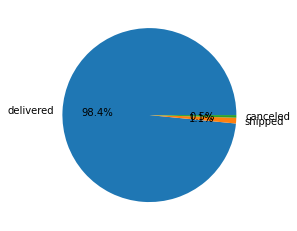

In [14]:
plt.pie(status, labels = status.index, autopct = '%1.1f%%');

In [15]:
def datetime_convert(columns, df):
    df[columns] = \
    df[columns].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')

In [17]:
datetime_convert(\
    ['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date'],order)

In [18]:
made_to_approved = (order['order_approved_at'] - order['order_purchase_timestamp']).mean()
approved_to_carrier = (order['order_delivered_carrier_date'] - order['order_approved_at']).mean()
carrier_to_customer = (order['order_delivered_customer_date'] - order['order_delivered_carrier_date']).mean()
seconds = [i/pd.Timedelta(hours = 1) for i in [made_to_approved,approved_to_carrier,carrier_to_customer]]
seconds

[10.419094301919445, 67.32091634747972, 223.9331261524286]

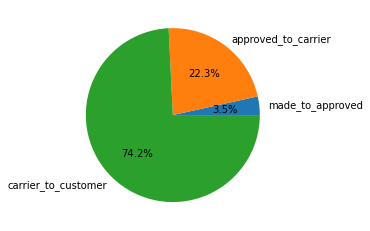

In [19]:
labels = 'made_to_approved', 'approved_to_carrier', 'carrier_to_customer'
plt.pie(seconds, labels=labels, autopct='%1.1f%%');

In [20]:
earlier = order.apply(lambda x: True if \
    x['order_estimated_delivery_date'] > x['order_delivered_customer_date'] else False, axis = 1).value_counts()
earlier

True     88649
False    10792
dtype: int64

([<matplotlib.patches.Wedge at 0x7f88a72226a0>,
 [Text(-1.0366824511953583, 0.3678172037623902, 'earlier than expected'),
  Text(1.036682468414123, -0.3678171552317824, 'longer than expected')],
 [Text(-0.5654631551974681, 0.20062756568857645, '89.1%'),
  Text(0.5654631645895215, -0.2006275392173358, '10.9%')])

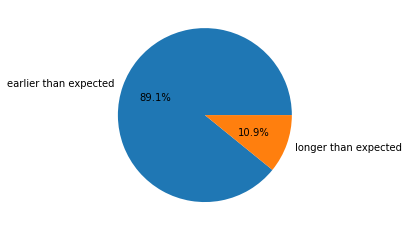

In [21]:
plt.pie(earlier, labels = ['earlier than expected','longer than expected'], autopct='%1.1f%%')

 Xây dựng các hub nhỏ tại các khu vực để giảm thời gian vận chuyển. Đa dạng hoá các carrier. 

2. Order items dataset

In [24]:
items = len(orderitems)
print('total items sold is {}'.format(items))

total items sold is 112650


In [27]:
rev = orderitems['price'].sum()
print('total revenue made is {}'.format(rev))

total revenue made is 13591643.700000001


In [30]:
shipfee = orderitems['freight_value'].sum()
print('total shipfee is {} $'.format(shipfee))

total shipfee is 2251909.54 $


3. Ordereviews

In [31]:
avg_review_score = orderreviews['review_score'].mean()
print('Average review score is {}'.format(avg_review_score))

Average review score is 4.07089


In [42]:
df.groupby('review_comment_title')['customer_id'].count().sort_values(ascending= False).nlargest(10)

review_comment_title
Recomendo          498
recomendo          404
Bom                332
super recomendo    311
Excelente          293
Muito bom          279
Ótimo              268
Super recomendo    257
Ótimo              238
Otimo              201
Name: customer_id, dtype: int64

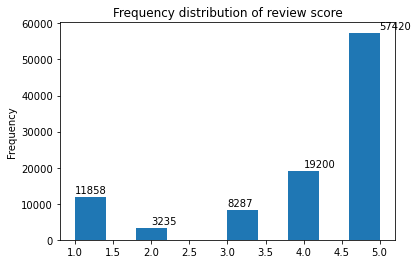

In [26]:
orderreviews.review_score.plot.hist()
plt.title('Frequency distribution of review score')
for i,v in enumerate(orderreviews['review_score'].value_counts().sort_index()):
    plt.text(i+1,v+1000,str(v))

4. Customer 

In [38]:
top10cus = df.groupby('customer_id')['order_id'].count().sort_values(ascending=False).head(10)
top10cus

customer_id
270c23a11d024a44c896d1894b261a83    63
13aa59158da63ba0e93ec6ac2c07aacb    38
9af2372a1e49340278e7c1ef8d749f34    29
92cd3ec6e2d643d4ebd0e3d6238f69e2    26
d22f25a9fadfb1abbc2e29395b1239f4    24
2ba91e12e5e4c9f56b82b86d9031d329    24
6ee2f17e3b6c33d6a9557f280edd2925    24
63b964e79dee32a3587651701a2b8dbf    24
86cc80fef09f7f39df4b0dbce48e81cb    24
b246eeed30b362c09d867b9e598bee51    22
Name: order_id, dtype: int64

In [32]:
top10payment = df.groupby('customer_unique_id')['price'].sum().sort_values(ascending = False).head(10)

/Users/huuchuyen0312/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


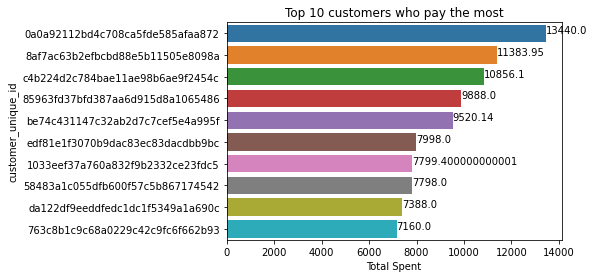

In [33]:
sns.barplot(top10cus, top10cus.index)
plt.xlabel('Total Spent')
plt.title('Top 10 customers who pay the most')
for i,v in enumerate(top10cus):
    plt.text(v,i,str(v));

5. Payment

In [39]:
payments = orderpay['payment_type'].value_counts()

/Users/huuchuyen0312/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


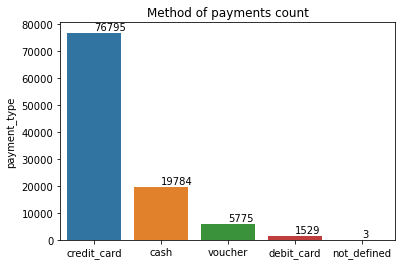

In [40]:
sns.barplot(payments.index, payments)
plt.title('Method of payments count')
for i,v in enumerate(payments):
    plt.text(i,v + 1000,str(v));

In [43]:
df['type_of_payment'] = ['one time payment' if x == 1 else 'installments payment' for x in df['payment_installments']]

In [44]:
paytype = df['type_of_payment'].value_counts()
paytype

installments payment    59370
one time payment        58945
Name: type_of_payment, dtype: int64

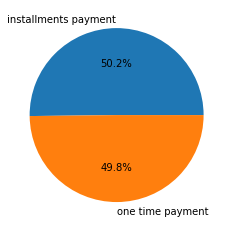

In [45]:
plt.pie(paytype, labels = paytype.index, autopct = '%1.1f%%');

In [46]:
df.groupby('product_category_name')['payment_value'].sum().nlargest(10).reset_index()

,product_category_name,payment_value
0,cama_mesa_banho,1744205.53
1,beleza_saude,1663076.30
2,informatica_acessorios,1599574.66
3,moveis_decoracao,1444383.69
4,relogios_presentes,1430553.48
5,esporte_lazer,1400270.11
6,utilidades_domesticas,1097900.09
7,automotivo,855095.68
8,ferramentas_jardim,840721.59
9,cool_stuff,781933.97


In [47]:
df.groupby('customer_city')['payment_value'].sum().sort_values(ascending=False).to_frame().head(10)

,payment_value
customer_city,
sao paulo,2869266.75
rio de janeiro,1574182.84
belo horizonte,504234.44
brasilia,434082.20
curitiba,331052.02
porto alegre,317384.38
salvador,290277.61
campinas,269008.51
goiania,213737.67
